In [1]:
# Install keras
!pip install keras

In [2]:
# Install Tensorflow
# Requires the latest pip
!pip install --upgrade pip

# Current stable release for CPU and GPU
!pip install tensorflow

# Or try the preview build (unstable)
!pip install tf-nightly

In [3]:
# Install pyTorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 2.0 MB/s eta 0:19:44
     ---------------------------------------- 0.0/2.4 GB 825.8 kB/s eta 0:48:55
     ---------------------------------------- 0.0/2.4 GB 660.6 kB/s eta 1:01:09
     ---------------------------------------- 0.0/2.4 GB 655.4 kB/s eta 1:01:38
     ---------------------------------------- 0.0/2.4 GB 1.1 MB/s eta 0:36:24
     ---------------------------------------- 0.0/2.4 GB 1.5 MB/s eta 0:26:08
     ---------------------------------------- 0.0/2.4 GB 2.1 MB/s eta 0:19:12
     ---------------------------------------- 0.0/2.4 GB 2.6 MB/s eta 0:15:33
     ---------------------------------------- 0.0/2.4 GB 2.9 MB/s eta 0:14:07
     ---------------------------------------- 0.0/2.4 GB 2.9 MB/s eta 0:13:52
     ---------------------------------------- 0.0/2.4 GB 2.9 MB/s eta 0:13:52
     -

In [1]:
# Tỉ lệ pha train, test
train_ratio = 0.8
test_ratio = 1.0 - train_ratio

In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

In [3]:
# 2. Đọc file csv và gắn index với giá Close
btc = pd.read_csv('./Cryptocurrencies/BTC.csv')
eth = pd.read_csv('./Cryptocurrencies/ETH.csv')
doge = pd.read_csv('./Cryptocurrencies/DOGE.csv')

date_index = btc
date_index['Date'] = pd.to_datetime(date_index.Date)
date_index.set_index('Date', inplace=True)
date_index = date_index[['Close']]

btc = btc.reset_index()['Close']
eth = eth.reset_index()['Close']
doge = doge.reset_index()['Close']

In [4]:
date_train_size = int(train_ratio * len(btc))
date_test_size = int(test_ratio * len(btc))

date_train_data = date_index[:date_train_size]
date_test_data = date_index[date_train_size:date_train_size+date_test_size]

In [5]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))

btc = scaler.fit_transform(np.array(btc).reshape(-1, 1))
eth = scaler.fit_transform(np.array(eth).reshape(-1, 1))
doge = scaler.fit_transform(np.array(doge).reshape(-1, 1))

In [6]:
# 4. Chia train test
# BTC
btc_train_size = int(train_ratio * len(btc))
btc_test_size = int(test_ratio * len(btc))

btc_train_data = btc[:btc_train_size]
btc_test_data = btc[btc_train_size:btc_train_size+btc_test_size]

# ETH
eth_train_size = int(train_ratio * len(eth))
eth_test_size = int(test_ratio * len(eth))

eth_train_data = eth[:eth_train_size]
eth_test_data = eth[eth_train_size:eth_train_size+eth_test_size]

# DOGE
doge_train_size = int(train_ratio * len(doge))
doge_test_size = int(test_ratio * len(doge))

doge_train_data = doge[:doge_train_size]
doge_test_data = doge[doge_train_size:doge_train_size+doge_test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  # i=0, X=0,1,2,3-----99, Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

# BTC
btc_x_train, btc_y_train = create_dataset(btc_train_data, time_step)
btc_x_test, btc_y_test = create_dataset(btc_test_data, time_step)

# ETH
eth_x_train, eth_y_train = create_dataset(eth_train_data, time_step)
eth_x_test, eth_y_test = create_dataset(eth_test_data, time_step)

# DOGE
doge_x_train, doge_y_train = create_dataset(doge_train_data, time_step)
doge_x_test, doge_y_test = create_dataset(doge_test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
# BTC
btc_x_train = btc_x_train.reshape(btc_x_train.shape[0], btc_x_train.shape[1], 1)
btc_x_test = btc_x_test.reshape(btc_x_test.shape[0], btc_x_test.shape[1], 1)

# ETH
eth_x_train = eth_x_train.reshape(eth_x_train.shape[0], eth_x_train.shape[1], 1)
eth_x_test = eth_x_test.reshape(eth_x_test.shape[0], eth_x_test.shape[1], 1)

# DOGE
doge_x_train = doge_x_train.reshape(doge_x_train.shape[0], doge_x_train.shape[1], 1)
doge_x_test = doge_x_test.reshape(doge_x_test.shape[0], doge_x_test.shape[1], 1)

In [10]:
# 8. Define GRU Model
# BTC
btc_model = Sequential()
btc_model.add(GRU(64, input_shape=(time_step, 1)))
btc_model.add(Dense(1))
btc_model.compile(optimizer='adam', loss='mean_squared_error')

# ETH
eth_model = Sequential()
eth_model.add(GRU(64, input_shape=(time_step, 1)))
eth_model.add(Dense(1))
eth_model.compile(optimizer='adam', loss='mean_squared_error')

# DOGE
doge_model = Sequential()
doge_model.add(GRU(64, input_shape=(time_step, 1)))
doge_model.add(Dense(1))
doge_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\tue05\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 9. Fit mô hình với dữ liệu train
btc_model.fit(btc_x_train, btc_y_train, validation_data=(
    btc_x_test, btc_y_test), epochs=100, batch_size=64, verbose=1)
eth_model.fit(eth_x_train, eth_y_train, validation_data=(
    eth_x_test, eth_y_test), epochs=100, batch_size=64, verbose=1)
doge_model.fit(doge_x_train, doge_y_train, validation_data=(
    doge_x_test, doge_y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0982 - val_loss: 0.0088
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0094 - val_loss: 0.0012
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.0104e-04 - val_loss: 8.1817e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.1512e-04 - val_loss: 7.9214e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 5.8832e-04 - val_loss: 7.4152e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.5939e-04 - val_loss: 7.2053e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.8918e-04 - val_loss: 7.1055e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.9919e-04 - val_loss: 6.4316e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.2828e-04 - val_loss: 6.3517e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3849e-04 - val_loss:

In [12]:
# 10. Dự báo dữ liệu test, val
# BTC
btc_train_predict = btc_model.predict(btc_x_train)
btc_y_pred = btc_model.predict(btc_x_test)

# ETH
eth_train_predict = eth_model.predict(eth_x_train)
eth_y_pred = eth_model.predict(eth_x_test)

# DOGE
doge_train_predict = doge_model.predict(doge_x_train)
doge_y_pred = doge_model.predict(doge_x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
# BTC
btc_train_predict = scaler.inverse_transform(btc_train_predict)
btc_y_pred = scaler.inverse_transform(btc_y_pred)

# ETH
eth_train_predict = scaler.inverse_transform(eth_train_predict)
eth_y_pred = scaler.inverse_transform(eth_y_pred)

# DOGE
doge_train_predict = scaler.inverse_transform(doge_train_predict)
doge_y_pred = scaler.inverse_transform(doge_y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
df_list = ['btc', 'eth', 'doge']


def mean_absolute_scaled_error(y_test, y_pred):
    # Calculate the mean absolute error of the predictions
    mae_pred = np.mean(np.abs(y_test - y_pred))
    
    # Calculate the mean absolute error of a naive forecast
    mae_naive = np.mean(np.abs(y_test[1:] - y_test[:-1]))
    
    # Calculate MASE
    mase = mae_pred / mae_naive
    
    return mase


for df in df_list:
    mase = mean_absolute_scaled_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))
    mape = mean_absolute_percentage_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))
    rmse = root_mean_squared_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))

    print(df.upper())
    print('MAPE:', mape)
    print('MASE:', mase)
    print('RMSE:', rmse, '\n')

BTC
MAPE: 4824.857251761912
MASE: 230638.9248136387
RMSE: 3228.8880116260284 

ETH
MAPE: 5460.040891309806
MASE: 144182.88320851233
RMSE: 876.2280095207251 

DOGE
MAPE: 4883.226699405563
MASE: 224732.0390552269
RMSE: 2647.919561887904 



In [15]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
# BTC
from numpy import array

btc_x_input = btc_train_data.reshape(1, -1)
btc_x_input.shape

temp_input = list(btc_x_input)
temp_input = temp_input[0].tolist()

num_rows, num_cols = btc_train_data.shape
btc_30_lst_output = []
btc_60_lst_output = []
btc_90_lst_output = []
n_steps = num_rows - 1

for d in [30, 60, 90]:
    print(f'BTC {d} days predicts:')
    i = 1
    
    while (i <= d):
        if (len(temp_input) > 100):
            # print(temp_input)
            x_input = np.array(temp_input[1:])
            print("Day {} input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            # print(x_input)
            yhat = btc_model.predict(x_input, verbose=0)
            print("Day {} output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            # print(temp_input)
            eval(f'btc_{d}_lst_output').extend(yhat.tolist())
            i = i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = btc_model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            eval(f'btc_{d}_lst_output').extend(yhat.tolist())
            i = i+1
    
    print('\n')

BTC 30 days predicts:
Day 1 input [0.00797186 0.00661429 0.00709948 ... 0.33582974 0.33578813 0.33746821]


Day 1 output [[0.33329874]]
Day 2 input [0.00661429 0.00709948 0.00693002 ... 0.33578813 0.33746821 0.33329874]
Day 2 output [[0.33102348]]
Day 3 input [0.00709948 0.00693002 0.01008479 ... 0.33746821 0.33329874 0.33102348]
Day 3 output [[0.3284846]]
Day 4 input [0.00693002 0.01008479 0.00938256 ... 0.33329874 0.33102348 0.32848459]
Day 4 output [[0.3258937]]
Day 5 input [0.01008479 0.00938256 0.00929692 ... 0.33102348 0.32848459 0.3258937 ]
Day 5 output [[0.32329285]]
Day 6 input [0.00938256 0.00929692 0.00931968 ... 0.32848459 0.3258937  0.32329285]
Day 6 output [[0.3206966]]
Day 7 input [0.00929692 0.00931968 0.00416424 ... 0.3258937  0.32329285 0.32069659]
Day 7 output [[0.31811062]]
Day 8 input [0.00931968 0.00416424 0.0042428  ... 0.32329285 0.32069659 0.31811062]
Day 8 output [[0.31553772]]
Day 9 input [0.00416424 0.0042428  0.004093   ... 0.32069659 0.31811062 0.31553772]
Day 9 output [[0.31297964]]
Day 10 input [0.0042428  0.004093   0.00244286 ... 0.31811062 0.31553772 0.3129

In [16]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
# ETH
from numpy import array

eth_x_input = eth_train_data.reshape(1, -1)
eth_x_input.shape

temp_input = list(eth_x_input)
temp_input = temp_input[0].tolist()

num_rows, num_cols = eth_train_data.shape
eth_30_lst_output = []
eth_60_lst_output = []
eth_90_lst_output = []
n_steps = num_rows - 1

for d in [30, 60, 90]:
    print(f'ETH {d} days predicts:')
    i = 1
    
    while (i <= d):
        if (len(temp_input) > 100):
            # print(temp_input)
            x_input = np.array(temp_input[1:])
            print("Day {} input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            # print(x_input)
            yhat = eth_model.predict(x_input, verbose=0)
            print("Day {} output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            # print(temp_input)
            eval(f'eth_{d}_lst_output').extend(yhat.tolist())
            i = i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = eth_model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            eval(f'eth_{d}_lst_output').extend(yhat.tolist())
            i = i+1
    
    print('\n')

ETH 30 days predicts:
Day 1 input [0.00133995 0.00125041 0.00120243 ... 0.10408191 0.10307221 0.10340299]
Day 1 output [[0.10307284]]
Day 2 input [0.00125041 0.00120243 0.00119645 ... 0.10307221 0.10340299 0.10307284]
Day 2 output [[0.10270847]]
Day 3 input [0.00120243 0.00119645 0.00120008 ... 0.10340299 0.10307284 0.10270847]
Day 3 output [[0.10229819]]
Day 4 input [0.00119645 0.00120008 0.00113966 ... 0.10307284 0.10270847 0.10229819]
Day 4 output [[0.10187301]]
Day 5 input [0.00120008 0.00113966 0.00110118 ... 0.10270847 0.10229819 0.10187301]
Day 5 output [[0.1014535]]
Day 6 input [0.00113966 0.00110118 0.0011229  ... 0.10229819 0.10187301 0.1014535 ]
Day 6 output [[0.10104802]]
Day 7 input [0.00110118 0.0011229  0.00095244 ... 0.10187301 0.1014535  0.10104802]
Day 7 output [[0.10065661]]
Day 8 input [0.0011229  0.00095244 0.00091748 ... 0.1014535  0.10104802 0.10065661]
Day 8 output [[0.10027587]]
Day 9 input [0.00095244 0.00091748 0.00095032 ... 0.10104802 0.10065661 0.10027587]

In [17]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
# DOGE
from numpy import array

doge_x_input = doge_train_data.reshape(1, -1)
doge_x_input.shape

temp_input = list(doge_x_input)
temp_input = temp_input[0].tolist()

num_rows, num_cols = doge_train_data.shape
doge_30_lst_output = []
doge_60_lst_output = []
doge_90_lst_output = []
n_steps = num_rows - 1

for d in [30, 60, 90]:
    print(f'DOGE {d} days predicts:')
    i = 1
    
    while (i <= d):
        if (len(temp_input) > 100):
            # print(temp_input)
            x_input = np.array(temp_input[1:])
            print("Day {} input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            # print(x_input)
            yhat = doge_model.predict(x_input, verbose=0)
            print("Day {} output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            # print(temp_input)
            eval(f'doge_{d}_lst_output').extend(yhat.tolist())
            i = i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = doge_model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            eval(f'doge_{d}_lst_output').extend(yhat.tolist())
            i = i+1
    
    print('\n')

DOGE 30 days predicts:
Day 1 input [0.01100825 0.00964997 0.01094311 ... 0.36100131 0.35931477 0.36001318]
Day 1 output [[0.3576172]]
Day 2 input [0.00964997 0.01094311 0.01129931 ... 0.35931477 0.36001318 0.3576172 ]
Day 2 output [[0.35639438]]
Day 3 input [0.01094311 0.01129931 0.01140526 ... 0.36001318 0.3576172  0.35639438]
Day 3 output [[0.35493168]]
Day 4 input [0.01129931 0.01140526 0.01015695 ... 0.3576172  0.35639438 0.35493168]
Day 4 output [[0.35344917]]
Day 5 input [0.01140526 0.01015695 0.00983928 ... 0.35639438 0.35493168 0.35344917]
Day 5 output [[0.35196382]]
Day 6 input [0.01015695 0.00983928 0.00992121 ... 0.35493168 0.35344917 0.35196382]
Day 6 output [[0.35048756]]
Day 7 input [0.00983928 0.00992121 0.005243   ... 0.35344917 0.35196382 0.35048756]
Day 7 output [[0.3490231]]
Day 8 input [0.00992121 0.005243   0.00495315 ... 0.35196382 0.35048756 0.3490231 ]
Day 8 output [[0.34757143]]
Day 9 input [0.005243   0.00495315 0.00477032 ... 0.35048756 0.3490231  0.34757143]

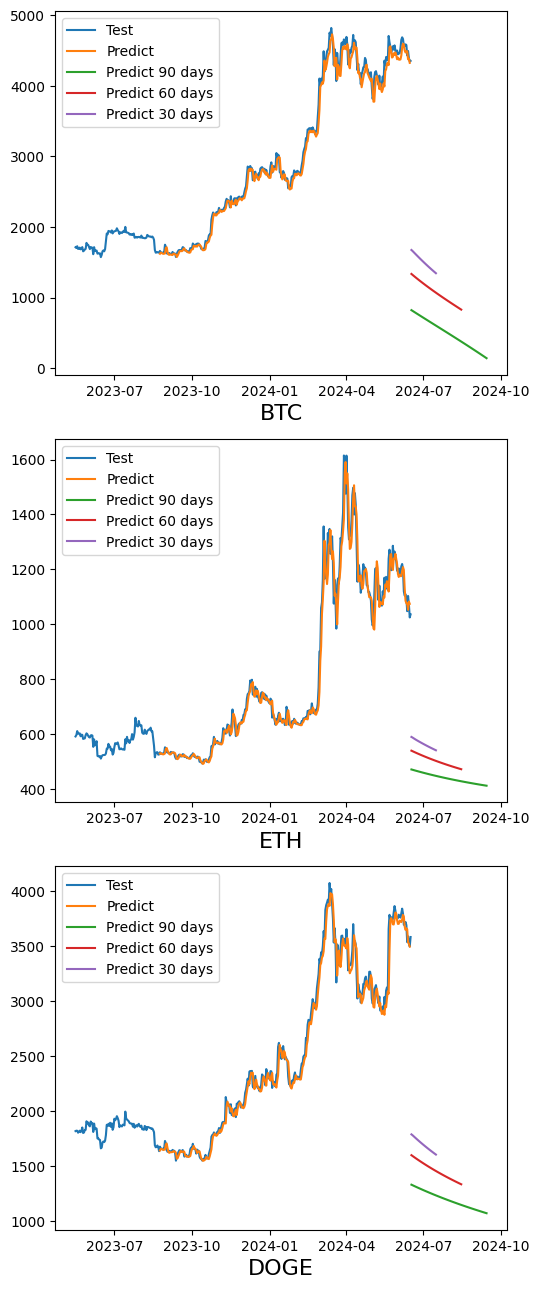

In [20]:
# 14.Vẽ hình
import matplotlib.dates as mdates

fig, axs = plt.subplots(3, 1, figsize=(5.5, 13))

last_test_date = date_test_data.index[-1]
pred_index = pd.date_range(start=date_test_data.index[99], periods=btc_test_size - 100, inclusive='right')
last_30_days_index = pd.date_range(start=last_test_date, periods=31, inclusive='right')
last_60_days_index = pd.date_range(start=last_test_date, periods=61, inclusive='right')
last_90_days_index = pd.date_range(start=last_test_date, periods=91, inclusive='right')

# BTC
# axs[0].plot(date_train_data.index, scaler.inverse_transform(btc_train_data))
axs[0].plot(date_test_data.index, scaler.inverse_transform(btc_test_data))
axs[0].plot(pred_index, btc_y_pred)
axs[0].plot(last_90_days_index, scaler.inverse_transform(btc_90_lst_output))
axs[0].plot(last_60_days_index, scaler.inverse_transform(btc_60_lst_output))
axs[0].plot(last_30_days_index, scaler.inverse_transform(btc_30_lst_output))
axs[0].legend(['Test', 'Predict', 'Predict 90 days', 'Predict 60 days', 'Predict 30 days'])

# ETH
# axs[1].plot(date_train_data.index, scaler.inverse_transform(eth_train_data))
axs[1].plot(date_test_data.index, scaler.inverse_transform(eth_test_data))
axs[1].plot(pred_index, (eth_y_pred))
axs[1].plot(last_90_days_index, scaler.inverse_transform(eth_90_lst_output))
axs[1].plot(last_60_days_index, scaler.inverse_transform(eth_60_lst_output))
axs[1].plot(last_30_days_index, scaler.inverse_transform(eth_30_lst_output))
axs[1].legend(['Test', 'Predict', 'Predict 90 days', 'Predict 60 days', 'Predict 30 days'])

# DOGE
# axs[2].plot(date_train_data.index, scaler.inverse_transform(doge_train_data))
axs[2].plot(date_test_data.index, scaler.inverse_transform(doge_test_data))
axs[2].plot(pred_index, (doge_y_pred))
axs[2].plot(last_90_days_index, scaler.inverse_transform(doge_90_lst_output))
axs[2].plot(last_60_days_index, scaler.inverse_transform(doge_60_lst_output))
axs[2].plot(last_30_days_index, scaler.inverse_transform(doge_30_lst_output))
axs[2].legend(['Test', 'Predict', 'Predict 90 days', 'Predict 60 days', 'Predict 30 days'])

axs[0].set_xlabel('BTC', fontsize=16)
axs[1].set_xlabel('ETH', fontsize=16)
axs[2].set_xlabel('DOGE', fontsize=16)

# Format x-axis to show only the year
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()